In [32]:
# import libraries
from tensorflow import keras
import numpy as np
import os
import time
import datetime
import h5py
import random
from scipy import spatial
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define the data location and load data
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
output_folder = os.path.join(pardir, "results", "video_pred_quan_eval_results")
data_folder = os.path.join(pardir,"data")
data_path = os.path.join(data_folder, "dataset_all",'video_prediction_dataset.hdf5')

print("data_folder:", data_folder)
print("data_path:", data_path)

data_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/data
data_path: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/data/dataset_all/video_prediction_dataset.hdf5


In [3]:
# load testing data
times_test = np.load(os.path.join(data_folder,"dataset_all","times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    #images_log_test = f['test']['images_log'][...]
    images_pred_test = f['test']['images_pred'][:,::2,:,:,:]

#print("images_log_test.shape:",images_log_test.shape)
print("images_pred_test.shape:",images_pred_test.shape)

times_test.shape: (4467,)
images_pred_test.shape: (4467, 8, 64, 64, 3)


In [4]:
# mask out img background
def mask_background(img): # put all background pixels to 0s
    mask_img = img.copy()
    for i in range(64):
        for j in range(64):
            if (i-30)**2+(j-30)**2>=31**2:
                mask_img[:,:,i,j,:]=0
    return mask_img

In [5]:
# normalize image
# mask out the background
mask_images_pred_test = mask_background(images_pred_test)
mask_images_pred_test = mask_images_pred_test.astype('float32')/255
print(mask_images_pred_test.shape)

(4467, 8, 64, 64, 3)


In [6]:
# calculate VGG cosine similarity
vgg16 = keras.applications.VGG16(weights='imagenet',include_top=True,pooling='max',input_shape=(224,224,3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
basemodel=keras.Model(inputs=vgg16.input,outputs=keras.layers.Flatten()(vgg16.get_layer('block4_pool').output))

In [8]:
def get_feature_vector3(img):
    #img1= cv2.resize(img,(224,224))
    #evaluate in batch 
    #feature_vector = np.zeros((img.shape[0],img.shape[1],basemodel.output.shape[-1]))
    img1 = img.reshape(-1,224,224,3)
    feature_vector = np.zeros((img1.shape[0],basemodel.output.shape[-1]))
    batch_size = 100
    num_samples = img1.shape[0]
    indices = np.arange(num_samples)
    for i in range(int(num_samples / batch_size) + 1):
    #for i in range(num_samples):
        #start_time = time.time()
        start_idx = (i * batch_size) % num_samples
        idxs = indices[start_idx:start_idx + batch_size]
        feature_vector[idxs] = basemodel.predict(img1[idxs])
        #feature_vector[i] = basemodel.predict(img[i])
        #end_time = time.time()
        #print("batch {0} samples: {1} to {2}, {3:.2f}% finished, processing time {4:.2f}s"
        #  .format(i+1, idxs[0],idxs[-1],(idxs[-1]/num_samples)*100,(end_time-start_time)))
    feature_vector=feature_vector.reshape((img.shape[0],img.shape[1],basemodel.output.shape[-1]))
    return feature_vector

In [9]:
mask_images_pred_test_resized = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1],224,224,3))
for i in range(images_pred_test.shape[0]):
    for j in range(images_pred_test.shape[1]):
        mask_images_pred_test_resized[i,j] = cv2.resize(mask_images_pred_test[i,j],(224,224))
feature_vector_gt_test = (get_feature_vector3(mask_images_pred_test_resized*255)).astype('float32')

In [10]:
def calculate_cosine_similarity(vector1, vector2):
    cosine_similarity = 1-spatial.distance.cosine(vector1,vector2)
    return cosine_similarity

In [11]:
feature_vector_gt_test.dtype

dtype('float32')

### Evaluation of model performance quantitatively

### VideoGPT (4x4x4)

In [12]:
# video prediction models for predicted images
def loadData(samp_num, vp_model, vp_model_folder):

    print("vp_model_folder:", vp_model_folder)

    # load predicted images
    predicted_images = np.load(os.path.join(vp_model_folder,"sample_" + str(samp_num) + ".npy"))[:,8:, :, :, :]
    predicted_images = mask_background(predicted_images.astype('float32'))
    
    predicted_images_resized = np.zeros((predicted_images.shape[0],predicted_images.shape[1],224,224,3))
    for i in range(predicted_images.shape[0]):
        for j in range(predicted_images.shape[1]):
            predicted_images_resized[i,j] = cv2.resize(predicted_images[i,j],(224,224))
    feature_vector_pred_test = (get_feature_vector3(predicted_images_resized*255)).astype('float32')
    print("predicted_images.shape:",predicted_images.shape)
    print("feature_vector_pred_test.shape:",feature_vector_pred_test.shape)
    
    return predicted_images, feature_vector_pred_test

In [13]:
def metrics(predicted_images, images_pred_test, feature_vector_gt, feature_vector_pred):    
    mse_per_frame = np.mean(np.sum((predicted_images-images_pred_test)**2,axis=(2,3,4)),axis=0)
    mae_per_frame = np.mean(np.sum(np.abs(predicted_images-images_pred_test),axis=(2,3,4)),axis=0)
    ssim_per_frame = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1]))
    cosine_similarity_per_frame = np.zeros((images_pred_test.shape[0],images_pred_test.shape[1]))
    
    for i in range(images_pred_test.shape[0]):
        for j in range(images_pred_test.shape[1]):
            ssim_per_frame[i,j] = ssim(images_pred_test[i,j], predicted_images[i,j], multichannel=True)
            
            # calcuate vgg cosine similarity
            cosine_similarity_per_frame[i,j] = calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector_pred[i,j])
        
    ssim_per_frame = np.mean(ssim_per_frame, axis=0)
    cosine_similarity_per_frame = np.mean(cosine_similarity_per_frame, axis=0)
    
    #np.save(os.path.join(output_folder,'VideoGPT_4x4x4_mse_avg'),mse_per_frame)
    #np.save(os.path.join(output_folder,'VideoGPT_4x4x4_mae_avg'),mae_per_frame)
    #np.save(os.path.join(output_folder,'VideoGPT_4x4x4_ssim_avg'),ssim_per_frame)
    np.save(os.path.join(output_folder,'VideoGPT_4x4x4_cosine_similarity_avg_block4_pool'),cosine_similarity_per_frame)
    
    for j in range(images_pred_test.shape[1]):
        print('-'*50)
        print('evaluation for {0} min'.format(j*2+1))
        print('mse (frame-wise): ', mse_per_frame[j])
        print('mae (frame-wise): ', mae_per_frame[j])
        print('ssim: ', ssim_per_frame[j])
        print('cosine_similarity: ', cosine_similarity_per_frame[j])

    print("*"*50)
    print('overall performance:')
    print('mse (frame-wise): ', np.mean(mse_per_frame))
    print('mae (frame-wise): ', np.mean(mae_per_frame))
    print('ssim: ', np.mean(ssim_per_frame))
    print('cosine_similarity: ', np.mean(cosine_similarity_per_frame))

In [24]:
from tqdm.notebook import tqdm

def metrics_batch(predicted_images, images_pred_test, feature_vector_gt, feature_vector_pred):
    mse_per_frame = np.mean(
        np.min(
            np.sum(
                (predicted_images-images_pred_test[None])**2,
                axis=(3,4,5)
                ),
            axis=0),
        axis=0
    )
    mae_per_frame = np.mean(
        np.min(
            np.sum(
                np.abs(predicted_images-images_pred_test[None]),
                axis=(3,4,5)
            ),
        axis=0),
    axis=0)
    
    ssim_per_frame = np.zeros((predicted_images.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
    cosine_similarity_per_frame = np.zeros((predicted_images.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
    
    for i in range(images_pred_test.shape[0]):
        for j in range(images_pred_test.shape[1]):
            for k in range(predicted_images.shape[0]):
                ssim_per_frame[k,i,j] = ssim(images_pred_test[i,j], predicted_images[k,i,j], multichannel=True)
                cosine_similarity_per_frame[k,i,j] = calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector_pred[k,i,j])
    
    #for i in range(images_pred_test.shape[0]):
    #    for j in range(images_pred_test.shape[1]):
    #        for pred_img in predicted_images[:, i, j]:
    #            ssim_per_frame[i,j] = max(
    #                ssim(images_pred_test[i,j], pred_img, multichannel=True),
    #                ssim_per_frame[i,j]
    #            )
    #        for feature_vector in feature_vector_pred[:,i,j,:]:
    #            cosine_similarity_per_frame[i,j] = max(
    #                calculate_cosine_similarity(feature_vector_gt[i,j],feature_vector),
    #                cosine_similarity_per_frame[i,j]
    #            )

    ssim_on_time_step = np.mean(np.max(ssim_per_frame, axis=0),axis=0)
    cosine_similarity_on_time_step = np.mean(np.max(cosine_similarity_per_frame, axis=0),axis=0)
    
    # take mean across all time stamps
    ssim_per_frame_mean = np.mean(ssim_per_frame, axis=2)
    cosine_similarity_per_frame_mean = np.mean(cosine_similarity_per_frame, axis=2)
    
    # find the best match across all 10 samplings and take the mean of every sample
    #ssim_per_frame_mean = np.mean(np.max(ssim_per_frame_mean,axis=0),axis=0)
    #cosine_similarity_per_frame_mean = np.mean(np.max(cosine_similarity_per_frame_mean,axis=0),axis=0)
    
    # find the index of the best/worst match across 10 samplings for every sample
    best_match_img_index = np.argmax(cosine_similarity_per_frame_mean,axis=0)
    worst_match_img_index = np.argmin(cosine_similarity_per_frame_mean,axis=0)
    
    #np.save(os.path.join(output_folder,'VideoGPT_4x4x4_mse_min'),mse_per_frame)
    #np.save(os.path.join(output_folder,'VideoGPT_4x4x4_mae_min'),mae_per_frame)
    np.save(os.path.join(output_folder,'VideoGPT_4x4x4_ssim_max_recalculated'),ssim_on_time_step)
    np.save(os.path.join(output_folder,'VideoGPT_4x4x4_cosine_similarity_max_block4pool'),cosine_similarity_on_time_step)
    np.save(os.path.join(output_folder,'best_match_img_index_based_on_cosine_similarity_among_10sampling_VideoGPT_4x4x4_block4_pool_features.npy'), best_match_img_index)
    np.save(os.path.join(output_folder,'worst_match_img_index_based_on_cosine_similarity_among_10sampling_VideoGPT_4x4x4_block4_pool_features.npy'), worst_match_img_index)
    
    for j in range(images_pred_test.shape[1]):
        print('-'*50)
        print('evaluation for {0} min'.format(j*2+1))
        print('mse (frame-wise): ', mse_per_frame[j])
        print('mae (frame-wise): ', mae_per_frame[j])
        print('ssim: ', ssim_on_time_step[j])
        print('cosine_similarity: ', cosine_similarity_on_time_step[j])
        
    print("*"*50)
    print('overall performance:')
    print('mse (frame-wise): ', np.mean(mse_per_frame))
    print('mae (frame-wise): ', np.mean(mae_per_frame))
    print('ssim: ', np.mean(ssim_on_time_step))
    print('cosine_similarity: ', np.mean(cosine_similarity_on_time_step))
    
    return cosine_similarity_per_frame, best_match_img_index, worst_match_img_index

In [16]:
#loop over all samples
samp_array  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print(images_pred_test.shape)

predicted_images_batch = []
feature_vector_pred_test_batch = []
for samp_num in samp_array:
    vp_model = "VideoGPT_2min_4x4x4_sample_" + str(samp_num)
    vp_model_folder = '/scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/VideoGPT_full_2min'
    print('Sample #: ', samp_num)
    predicted_images, feature_vector_pred_test = loadData(samp_num, vp_model, vp_model_folder)
    predicted_images_batch.append(predicted_images.astype('float32'))
    feature_vector_pred_test_batch.append(feature_vector_pred_test)

(4467, 8, 64, 64, 3)
Sample #:  0
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/VideoGPT_full_2min
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  1
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/VideoGPT_full_2min
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  2
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/VideoGPT_full_2min
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  3
vp_model_folder: /scratch/groups/abrandt/solar_forecasting/GAN_project_new/models/VideoGPT/inference/VideoGPT_full_2min
predicted_images.shape: (4467, 8, 64, 64, 3)
feature_vector_pred_test.shape: (4467, 8, 100352)
Sample #:  4
vp_model_folder: /scratch/groups/abrandt/solar_forecas

In [22]:
metrics(np.stack(predicted_images_batch).mean(0), mask_images_pred_test,feature_vector_gt_test,np.stack(feature_vector_pred_test_batch).mean(0))

--------------------------------------------------
evaluation for 1 min
mse (frame-wise):  24.947094
mae (frame-wise):  291.51633
ssim:  0.890761594219865
cosine_similarity:  0.7956955496272652
--------------------------------------------------
evaluation for 3 min
mse (frame-wise):  35.66165
mae (frame-wise):  355.5691
ssim:  0.8651576682044281
cosine_similarity:  0.7833255618003382
--------------------------------------------------
evaluation for 5 min
mse (frame-wise):  43.656013
mae (frame-wise):  399.5052
ssim:  0.8497744170766347
cosine_similarity:  0.7735329569386827
--------------------------------------------------
evaluation for 7 min
mse (frame-wise):  50.17848
mae (frame-wise):  434.36377
ssim:  0.8390627726853852
cosine_similarity:  0.7647140698195944
--------------------------------------------------
evaluation for 9 min
mse (frame-wise):  55.20639
mae (frame-wise):  459.52588
ssim:  0.8313261260745035
cosine_similarity:  0.7583314360642502
-------------------------------

In [25]:
cosine_similarity, best_match_img_index, worst_match_img_index = metrics_batch(np.stack(predicted_images_batch), mask_images_pred_test, feature_vector_gt_test, np.stack(feature_vector_pred_test_batch))

--------------------------------------------------
evaluation for 1 min
mse (frame-wise):  27.720184
mae (frame-wise):  302.92438
ssim:  0.8823216264631143
cosine_similarity:  0.7624971956141395
--------------------------------------------------
evaluation for 3 min
mse (frame-wise):  38.532486
mae (frame-wise):  362.92456
ssim:  0.8556056885090755
cosine_similarity:  0.7438174404632546
--------------------------------------------------
evaluation for 5 min
mse (frame-wise):  45.655457
mae (frame-wise):  401.26743
ssim:  0.8402210531885606
cosine_similarity:  0.7313974852633471
--------------------------------------------------
evaluation for 7 min
mse (frame-wise):  50.729412
mae (frame-wise):  429.15485
ssim:  0.8306120032148608
cosine_similarity:  0.7222640416166888
--------------------------------------------------
evaluation for 9 min
mse (frame-wise):  54.91339
mae (frame-wise):  449.88254
ssim:  0.8234377169121144
cosine_similarity:  0.7146154165214571
--------------------------

In [26]:
predicted_images_batch_stacked = np.stack(predicted_images_batch)
feature_vector_pred_test_batch_stacked = np.stack(feature_vector_pred_test_batch)
#cosine_similarity = np.zeros((feature_vector_pred_test_batch_stacked.shape[0],images_pred_test.shape[0],images_pred_test.shape[1]))
#cosine_similarity_mean = np.zeros((feature_vector_pred_test.shape[0],images_pred_test.shape[0]))
#best_match_img_index = np.zeros(images_pred_test.shape[0])
#for i in range(images_pred_test.shape[0]):
#    for j in range(images_pred_test.shape[1]):
#        for k in range(feature_vector_pred_test_batch_stacked.shape[0]):
#            cosine_similarity[k,i,j] = calculate_cosine_similarity(feature_vector_gt_test[i,j],feature_vector_pred_test_batch_stacked[k,i,j])
#
#cosine_similarity_mean = np.mean(cosine_similarity,axis=2)
#best_match_img_index = np.argmax(cosine_similarity_mean,axis=0)
#worst_match_img_index = np.argmin(cosine_similarity_mean,axis=0)

In [ ]:
np.save(os.path.join(output_folder,'predicted_images_10sampling_stacked_mask_background_VideoGPT_4x4x4.npy'),predicted_images_batch_stacked)

0.6588980555534363
0.632074236869812


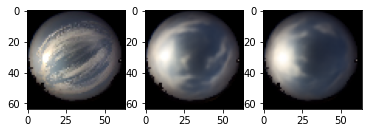

In [33]:
sample_no = 100
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[best_match_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))
#plt.show()

0.8502145409584045
0.804064154624939


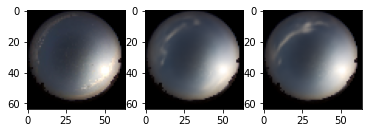

In [37]:
sample_no = 500
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[best_match_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))
#plt.show()

0.579323947429657
0.5764957070350647


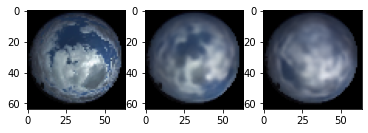

In [38]:
sample_no = 3445
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[best_match_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))
#plt.show()

0.5989739894866943
0.5609511137008667


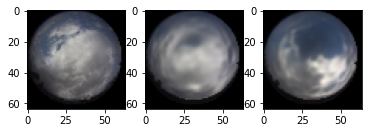

In [39]:
sample_no = 2484
f,ax=plt.subplots(1,3)
ax[0].imshow(mask_images_pred_test[sample_no,7][:,:,::-1])
ax[1].imshow(predicted_images_batch_stacked[best_match_img_index[sample_no],sample_no,7][:,:,::-1])
ax[2].imshow(predicted_images_batch_stacked[worst_match_img_index[sample_no],sample_no,7][:,:,::-1])
f1 = feature_vector_gt_test[sample_no,7]
f2 = feature_vector_pred_test_batch_stacked[best_match_img_index[sample_no],sample_no,7]
f3 = feature_vector_pred_test_batch_stacked[worst_match_img_index[sample_no],sample_no,7]
print(calculate_cosine_similarity(f1,f2))
print(calculate_cosine_similarity(f1,f3))
plt.show()

In [ ]:
def get_feature_vector(img):
    img1 = cv2.resize(img, (224, 224))
    feature_vector = basemodel.predict(img1.reshape(1, 224, 224, 3))
    return feature_vector

In [45]:
f1 = get_feature_vector(mask_images_pred_test[2484,7]*255)
f2 = get_feature_vector(predicted_images_batch_stacked[4,2484,7]*255)
calculate_cosine_similarity(f1,f2)

0.6067919135093689

In [62]:
# extract feature after 'flatten' layer
for i in range(8):
    f1 = get_feature_vector(mask_images_pred_test[2484,i]*255)
    f2 = get_feature_vector(predicted_images_batch_stacked[4,2484,i]*255)
    print(calculate_cosine_similarity(f1,f2))

0.7026278376579285
0.7122381329536438
0.7057576179504395
0.7329254150390625
0.6574621200561523
0.6038510203361511
0.5387664437294006
0.6067919135093689


In [63]:
# extract feature after 'flatten' layer
for i in range(8):
    f1 = get_feature_vector(mask_images_pred_test[2484,i]*255)
    f2 = get_feature_vector(predicted_images_batch_stacked[1,2484,i]*255)
    print(calculate_cosine_similarity(f1,f2))

0.7172203063964844
0.6712862253189087
0.6152684092521667
0.681306779384613
0.6539974212646484
0.5859021544456482
0.5625384449958801
0.5813878178596497


In [65]:
# extract feature after 'block4_pool' layer
for i in range(8):
    f1 = (get_feature_vector(mask_images_pred_test[2484,i]*255)).flatten()
    f2 = (get_feature_vector(predicted_images_batch_stacked[4,2484,i]*255)).flatten()
    print(calculate_cosine_similarity(f1,f2))

0.6852543354034424
0.666771650314331
0.6469346284866333
0.6417223811149597
0.611781656742096
0.5652930736541748
0.5616034269332886
0.5609508156776428


In [66]:
# extract feature after 'block4_pool' layer
for i in range(8):
    f1 = (get_feature_vector(mask_images_pred_test[2484,i]*255)).flatten()
    f2 = (get_feature_vector(predicted_images_batch_stacked[1,2484,i]*255)).flatten()
    print(calculate_cosine_similarity(f1,f2))

0.6941825151443481
0.6776711344718933
0.6389331817626953
0.6477095484733582
0.635533332824707
0.6118957996368408
0.6201027035713196
0.6151658296585083


In [67]:
# extract feature after 'block4_pool' layer
for i in range(8):
    f1 = (get_feature_vector(mask_images_pred_test[2484,i]*255)).flatten()
    f2 = (get_feature_vector(predicted_images_batch_stacked[2,2484,i]*255)).flatten()
    print(calculate_cosine_similarity(f1,f2))

0.6898453831672668
0.6569990515708923
0.6417195200920105
0.637258768081665
0.6186765432357788
0.6080988645553589
0.5985993146896362
0.5709738731384277


In [58]:
# extract feature after 'block3_pool' layer
for i in range(8):
    f1 = (get_feature_vector(mask_images_pred_test[2484,i]*255)).flatten()
    f2 = (get_feature_vector(predicted_images_batch_stacked[4,2484,i]*255)).flatten()
    print(calculate_cosine_similarity(f1,f2))

0.6385773420333862
0.6013059616088867
0.5982697606086731
0.5942062139511108
0.5808863639831543
0.5435407757759094
0.5171476602554321
0.4980105459690094


In [59]:
# extract feature after 'block3_pool' layer
for i in range(8):
    f1 = (get_feature_vector(mask_images_pred_test[2484,i]*255)).flatten()
    f2 = (get_feature_vector(predicted_images_batch_stacked[1,2484,i]*255)).flatten()
    print(calculate_cosine_similarity(f1,f2))

0.6555970311164856
0.6312924027442932
0.6038996577262878
0.6020829081535339
0.5945149660110474
0.5906843543052673
0.5780282020568848
0.562574565410614


In [60]:
# extract feature after 'block3_pool' layer
for i in range(8):
    f1 = (get_feature_vector(mask_images_pred_test[2484,i]*255)).flatten()
    f2 = (get_feature_vector(predicted_images_batch_stacked[2,2484,i]*255)).flatten()
    print(calculate_cosine_similarity(f1,f2))

0.6589879989624023
0.5928612947463989
0.5936031937599182
0.5844277739524841
0.589310348033905
0.5610323548316956
0.5525532364845276
0.5245020985603333
